In [23]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 14.6 MB/s eta 0:00:00


#Time series with a strong trend (WPI dataset)

In [61]:
import pandas as pd


In [35]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

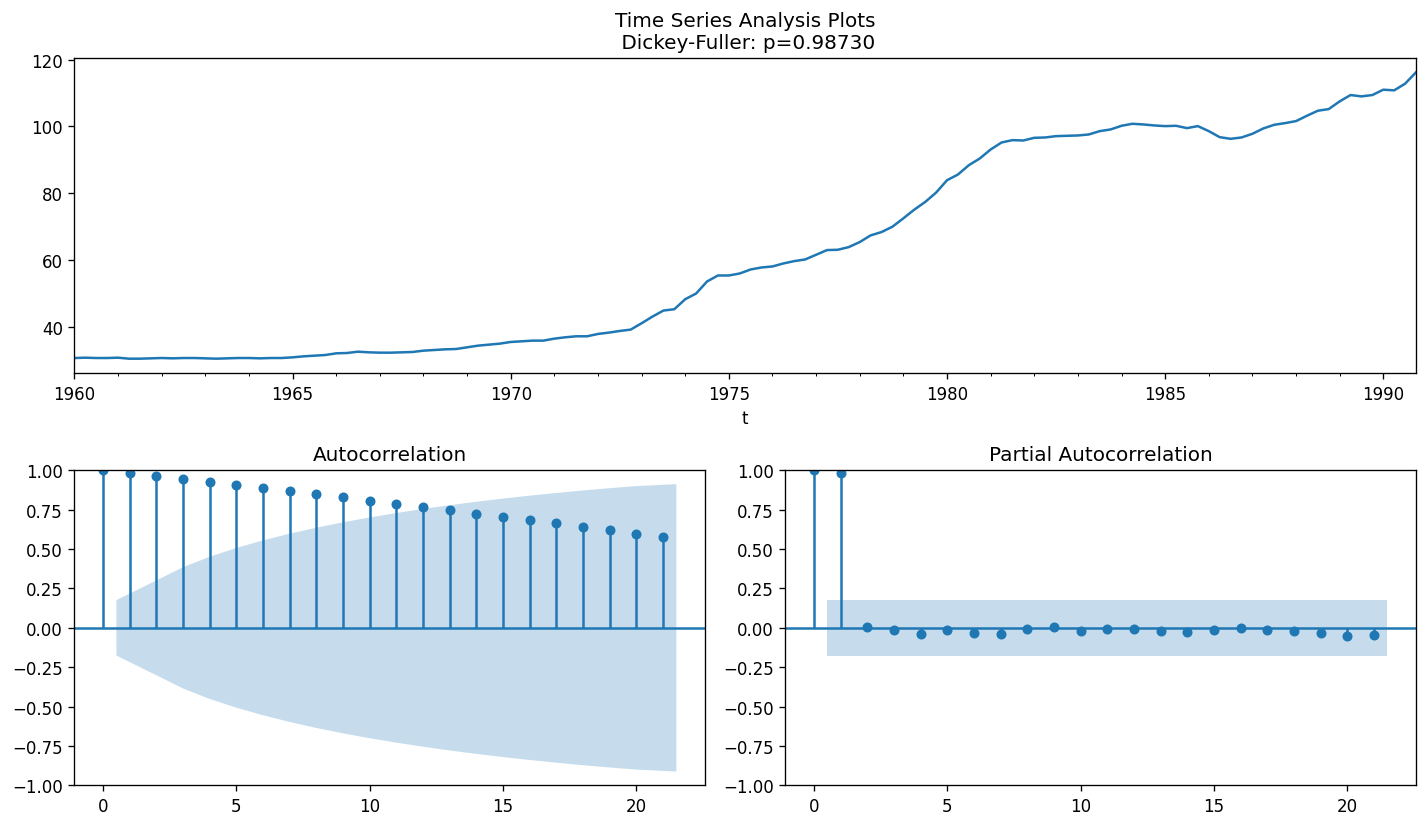

In [36]:
import requests
from io import BytesIO
wpi1 = requests.get("https://www.stata-press.com/data/r12/wpi1.dta").content
data = pd.read_stata(BytesIO(wpi1))
ts_wpi = data.set_index("t").wpi

tsplot(ts_wpi)

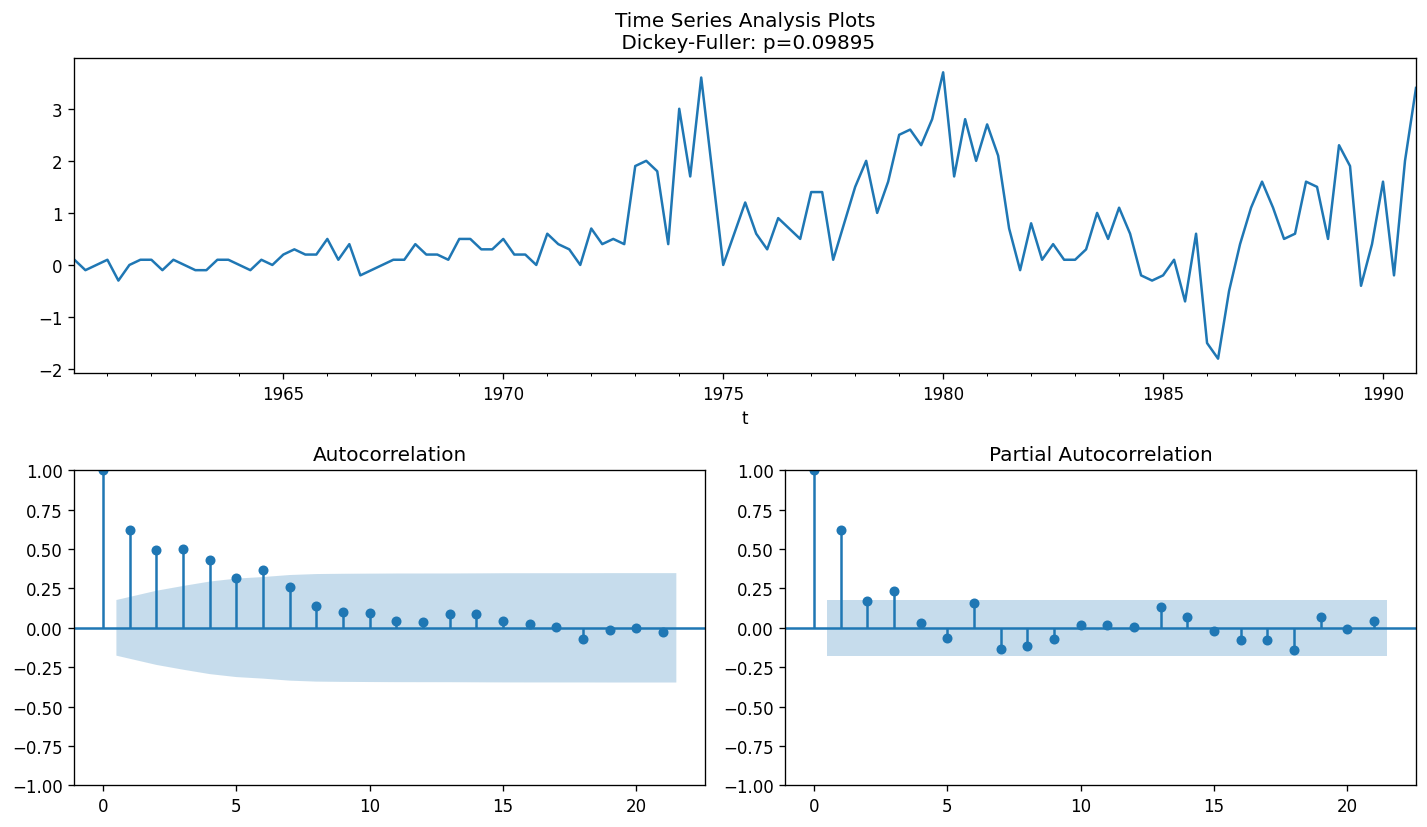

In [37]:

ts_wpi_diff = ts_wpi.diff().dropna()
tsplot(ts_wpi_diff)

In [43]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

In [39]:

ts_wpi.index = ts_wpi.index.to_period("Q")
test_len = int(len(ts_wpi) * 0.25)
wpi_train, wpi_test = ts_wpi.iloc[:-test_len], ts_wpi.iloc[-test_len:]

In [64]:

from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
import lightgbm as lgb

def create_forecaster():

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

    return forecaster


def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid,
        scoring=MeanAbsolutePercentageError(symmetric=True)
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape

/usr/local/lib/python3.10/dist-packages/sktime/forecasting/model_selection/_tune.py:201: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.27.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 68, number of used features: 25
[LightGBM] [Info] Start training from score 56.304412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

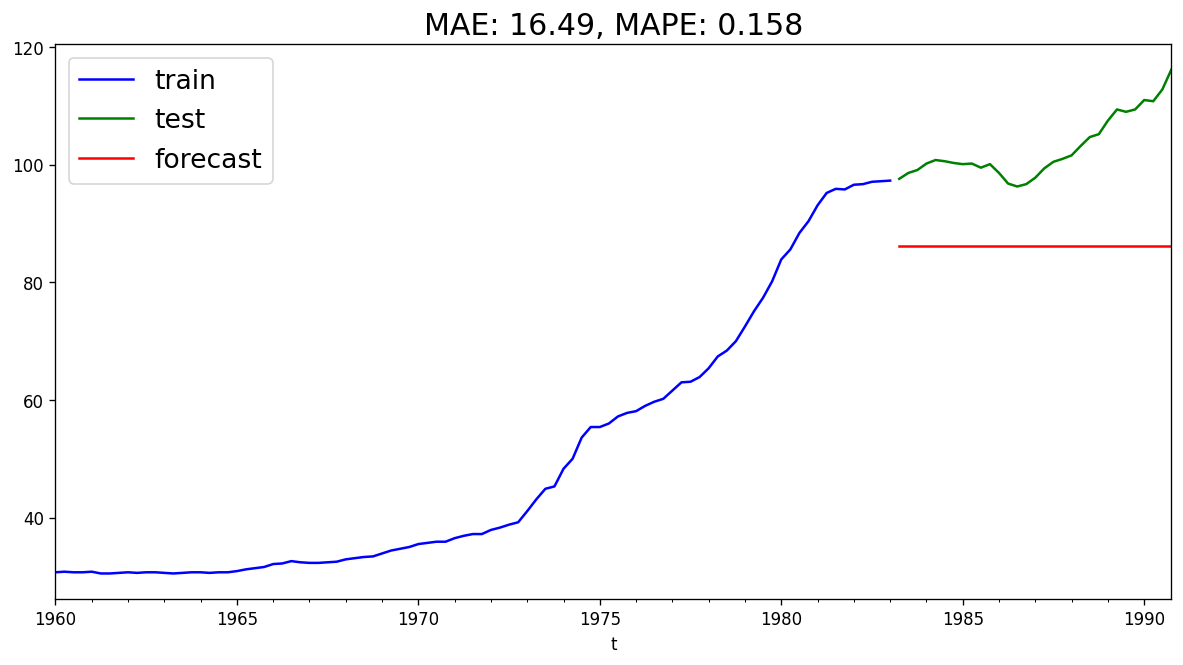

In [44]:
param_grid = {"window_length": [5, 10, 15, 20, 25, 30]}
forecaster = create_forecaster()
wpi_lgb_mae, wpi_lgb_mape = grid_serch_forecaster(
    wpi_train, wpi_test, forecaster, param_grid
)

#DETRENDING


/usr/local/lib/python3.10/dist-packages/sktime/forecasting/model_selection/_tune.py:201: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.27.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 68, number of used features: 25
[LightGBM] [Info] Start training from score -2.538334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

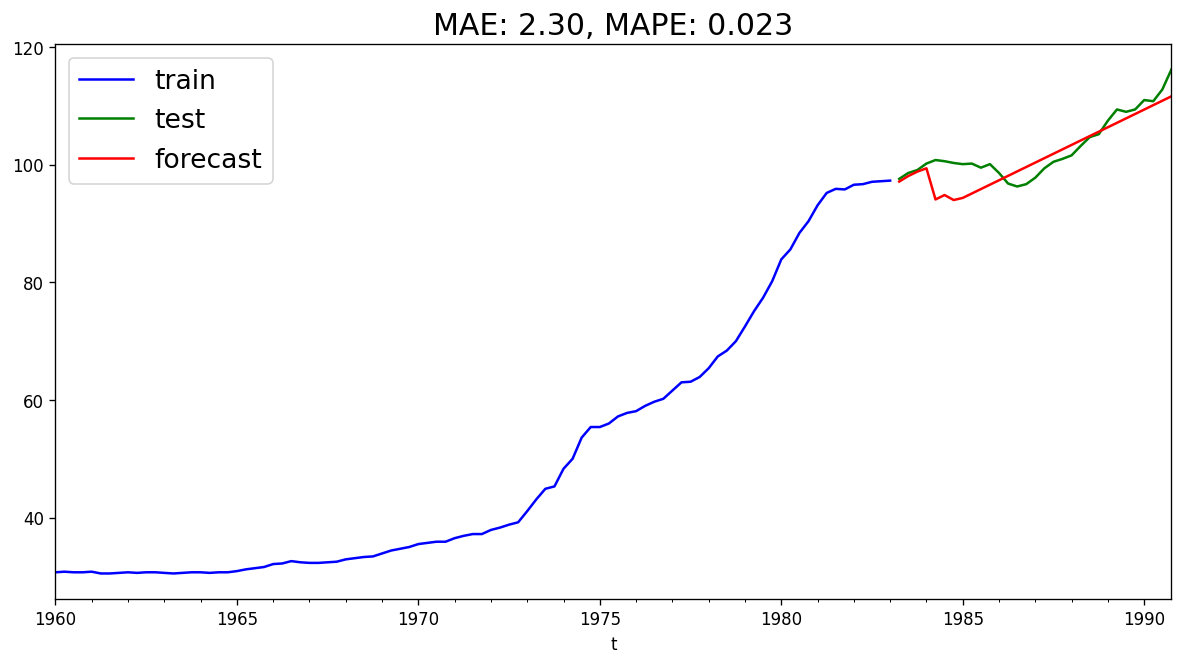

In [46]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender

def create_forecaster_w_detrender(degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=5, strategy="recursive"),
            ),
        ]
    )

    return forecaster


param_grid = {"forecast__window_length": [5, 10, 15, 20, 25, 30]}
forecaster = create_forecaster_w_detrender(degree=1)
wpi_lgb_mae, wpi_lgb_mape = grid_serch_forecaster(
    wpi_train, wpi_test, forecaster, param_grid
)

#Time series with trend and seasonality (Airline dataset)

In [52]:

from sktime.datasets import load_airline
ts_al = load_airline()

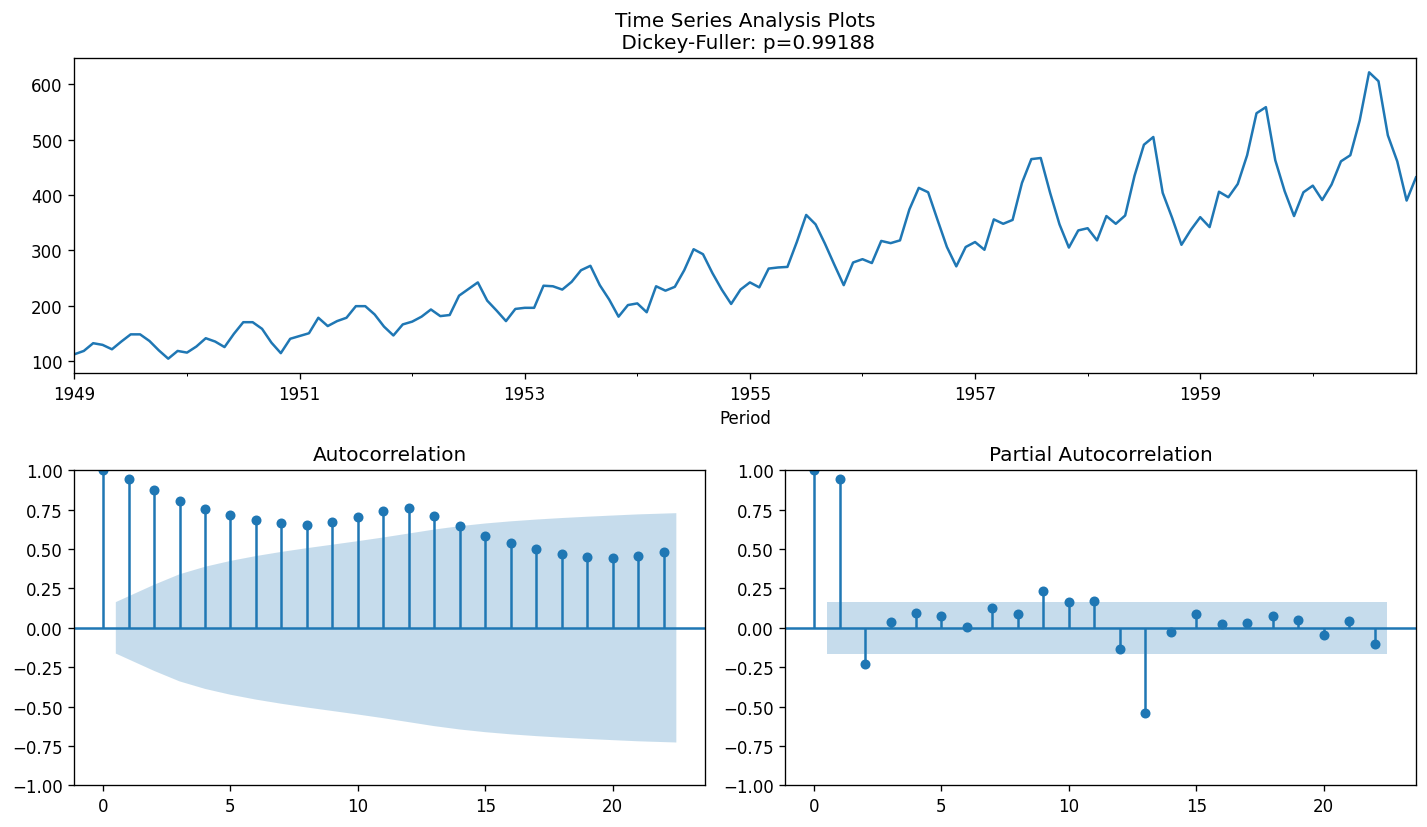

In [53]:
tsplot(ts_al)

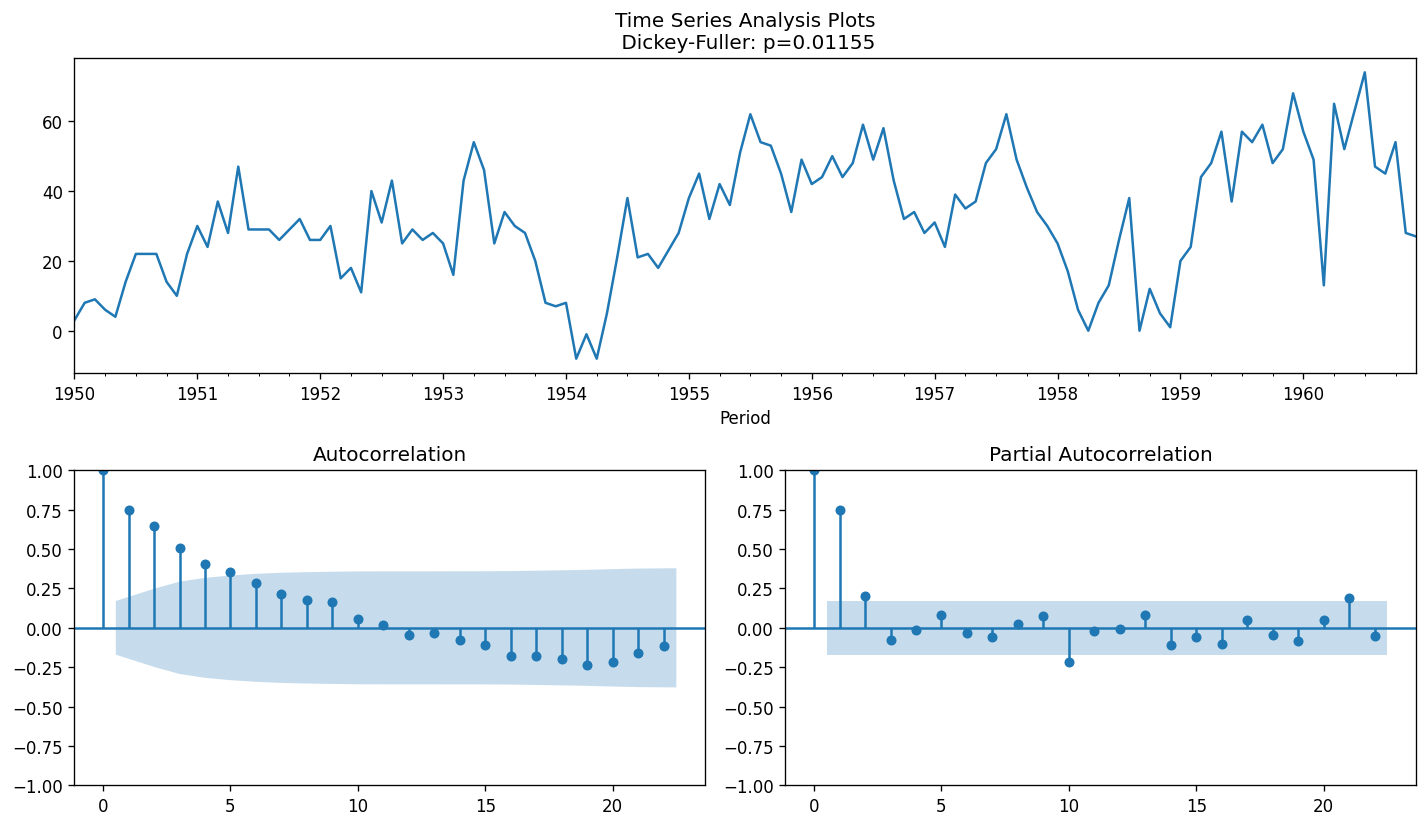

In [54]:
ts_al_diff = ts_al.diff(12).dropna()
tsplot(ts_al_diff)

In [59]:
test_len = int(len(ts_al) * 0.3)
al_train, al_test = ts_al.iloc[:-test_len], ts_al.iloc[-test_len:]

#DETREND AND DESEASONALIZE

/usr/local/lib/python3.10/dist-packages/sktime/forecasting/model_selection/_tune.py:201: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.27.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 12
[LightGBM] [Info] Start training from score -1.688051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

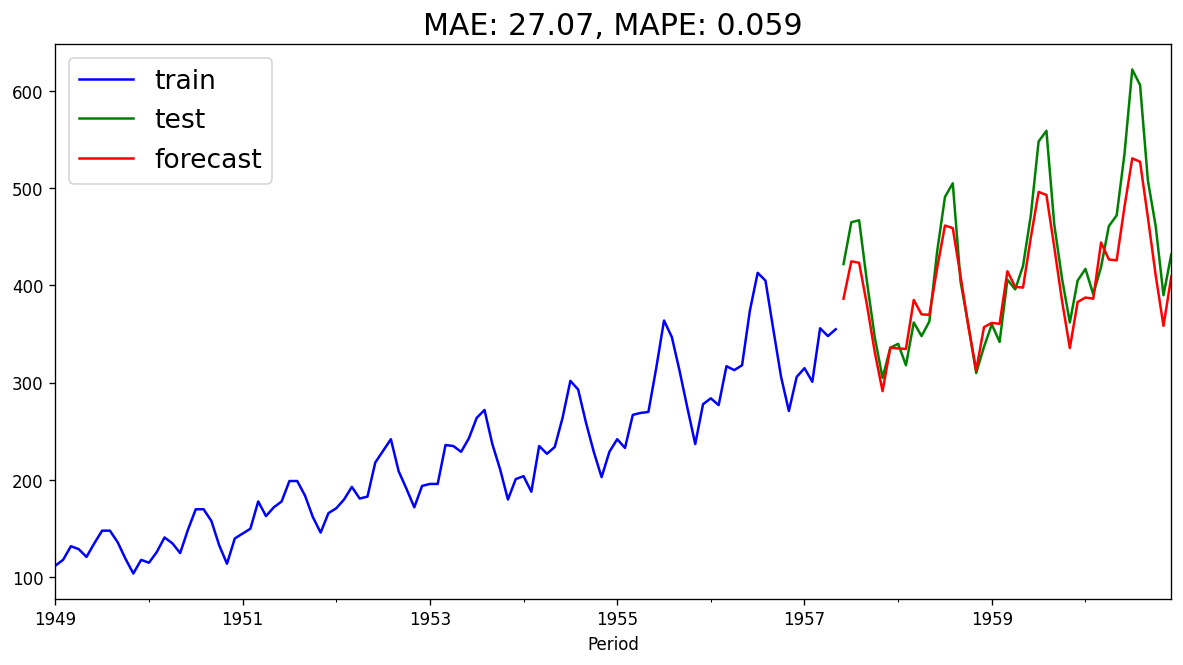

In [60]:
from sktime.transformations.series.detrend import Deseasonalizer

def create_forecaster_w_desesonalizer(sp=12, degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="multiplicative", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=12, strategy="recursive"),
            ),
        ]
    )

    return forecaster

forecaster = create_forecaster_w_desesonalizer()
param_grid = {"forecast__window_length": [6, 12, 18, 24, 30, 36]}

al_lgb_mae, al_lgb_mape = grid_serch_forecaster(
    al_train, al_test, forecaster, param_grid
)